In [1]:
from project.models.char_baseline import CharSeqBaseline
from project.models.code2vec_solo import Code2VecSolo
from project.models.code2vec_encoder import Code2VecEncoder
from project.models.base_model import _run_model


/home/ehambro/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
load_dir = {"logdir":"logs/new_attention_fourfive_c2v_solo_canond0.1/best_bleu", "mode":"RETURN"}
LOADED = _run_model(Code2VecSolo, **load_dir)

LOADING FROM: logs/new_attention_fourfive_c2v_solo_canond0.1/best_bleu, overwriting kwargs


Loading GloVe weights and word to index lookup table


400000it [00:07, 53444.73it/s]


Creating char to index look up table
Tokenizing the word descriptions and characters
Tokenizing the src code
Extracting tensors train and test
INFO:tensorflow:Restoring parameters from logs/new_attention_fourfive_c2v_solo_canond0.1/best_bleu/BasicModel.ckpt-36005


0821_23:06 WARNING - Loaded from logs/new_attention_fourfive_c2v_solo_canond0.1/best_bleu: Global Step 36005


In [3]:
from project.data.preprocessed.no_dups_X import no_dups_X_data


from project.data.preprocessed import load_vocab

from project.utils.tokenize import nltk_tok
from tqdm import tqdm


path2idx, path2cnt = load_vocab('no_dups_X', 'quickload_paths')
tv2idx, tv2cnt = load_vocab('no_dups_X', 'quickload_tvs')
idx2tv = {v:k for k,v in tv2idx.items()}
idx2path ={v:k for k,v in path2idx.items()}
RAW_TEST_DATA = no_dups_X_data().test
sess, nn, data_tuple, step = LOADED

In [4]:
import random
import numpy as np
from tqdm import tqdm 
from project.external.nmt import bleu


def prep_samples(translations, sample_size, no_samples):
    for n in range(no_samples):
        yield  random.choices(translations, k=sample_size)
        
def get_translations(nn, data):
    return nn.evaluate_bleu(sess, data, max_translations=10000)

def get_bleu_bootstrap(translations, sample_size = 1000, no_samples = 1000):
    bleu_bootstrap = []
    total = []
    for sample in prep_samples(translations, sample_size, no_samples):
        all_references = [[t.description] for t in sample]
        all_translations = [t.translation for t in sample ]
        b = bleu.compute_bleu(all_references, all_translations, max_order=4, smooth=False)
        bleu_bootstrap.append(b[0]*100)
    return bleu_bootstrap
    

In [5]:
from collections import defaultdict
import numpy 
from matplotlib import pyplot as plt
def translate_paths(paths, tvs):
    return["{} : {}".format(idx2path[p], idx2tv[t]) for p,t in zip(np.trim_zeros(paths), np.trim_zeros(tvs))]

def translate_paths_latex(paths, tvs):
    return["{} : \mintinline[]{python}{{}}".format(idx2path[p], idx2tv[t]) for p,t in zip(np.trim_zeros(paths), np.trim_zeros(tvs))]
def gen_combined_dataset(data_tuple_test):
    
    combined= []
    DESC_TO_D = defaultdict(list)
    [DESC_TO_D["".join(nltk_tok(f['arg_desc']))].append(f) for f in RAW_TEST_DATA]
    
    for i, d in enumerate(zip(*data_tuple_test)):
        matches = []
        for f in DESC_TO_D["".join(d[-1])]:
            arg_name = "".join(nn.translate(d[0], lookup=nn.idx2char, do_join=False))
            src_tokens = [idx2tv[t] for t in d[3] if t not in [0,1]]
            if arg_name.startswith(f['arg_name']) and all([str(s) in f['src'] for s in src_tokens]):
                
                matches.append((d,f, translate_paths(np.trim_zeros(d[2]),np.trim_zeros(d[3]))))
            
            if len(matches) > 1:
                break
        
        if len(matches)==1:
            combined.append(matches[0])
    return combined
        
COMB = gen_combined_dataset(data_tuple.test) 

In [6]:
def stack_from_comb(comb,x):   
    return [np.stack([d[i] for d, src,  p in comb][:x]) for i in range(4)] + [[d[-1] for d, src,  p in comb][:x]]
INPUT_STACKED = stack_from_comb(COMB, 63)  
nn._do_shuffle = False
T300  = get_translations(nn, INPUT_STACKED)

In [7]:
# import project.utils.code_tokenize as ct
# for i,  (t,c) in enumerate(zip(T300[-1], COMB)):
#     print(i, t)
#     print()
#     print(i, ct.get_pure_src(c[1]))
    
        

In [8]:
def print_light_table(labels, ptvs):
    # HACK
    to_tex = lambda  s:s.replace("<U", "$<$U").replace("K>", "K$>$").replace("_","\\_").replace("<-", "$\leftarrow$").replace("->", "$\\rightarrow$")
    
    reverse_this = []
    reverse_this.append("\end{tabular}")
    for l, p in zip(labels, ptvs):
        reverse_this.append(to_tex("    {} & {} \\\\".format(l, p)))
    reverse_this.append("\\begin{tabular}{c l}")
    print("\n".join(reversed(reverse_this)))

def translate_paths_latex(paths, tvs):
    return["{} : \mintinline[]{}{}".format(idx2path[p], "{python}","{"+idx2tv[t]+"}") for p,t in zip(np.trim_zeros(paths), np.trim_zeros(tvs))]
    
def plot_attention_single(attn, trans, paths, tvs, figsize=(10,5)):

    fig, ax = plt.subplots(1,figsize=figsize )
    ax = [ax]
    j=0
    
    F="ABCDEFGHIJKLMNOPQRSTUVWXYZ"
    attention = [a for a in np.trim_zeros(attn)]
    ptvs = translate_paths_latex(paths, tvs)
    
    attention, ptvs = zip(*sorted(zip(attention, ptvs), key=lambda x:x[0]))
    labels = ["Path {}".format(F[i] if i < len(F) else i) for i in reversed(range(len(ptvs)))]
    
    
    ax[j].barh(np.arange(len(attention)), attention)
    
    ax[j].set_title("Attention Scores per Path".format(F[j]), fontsize=22) #loc="right", fontsize=18)
    ax[j].set_yticks(np.arange(len(labels)))
    ax[j].set_yticklabels( labels, rotation=0,  fontsize=18)
    ax[j].set_ylabel("Paths", fontsize=22)
    ax[j].set_xlabel("Attention Scores", fontsize=22)
    
    print_light_table(labels,ptvs)
#     plt.tight_layout()
    plt.show()

In [9]:
def latex_translation(t):
    to_tex = lambda  s:s.replace("<", "$<$").replace(">", "$>$").replace("_","\\_")
    split = 25
    n1 = t[0][:split]
    n1 = "\\textbf{Argument}: \mintinline[]{python}{" + to_tex("".join(n1)) + "}"
    if len(t[0]) > split:
        n1 += "...\\\\\n...\mintinline[]{python}{"+to_tex(" ".join(t[0][split:])) + "}"
    n1 += "\\\\"
    desc = "\\textbf{D}: " + to_tex(" ".join(t[1])) + "\\\\"
    pred = "\\textbf{P}: " + to_tex(" ".join(t[3])) + "\\\\"
    return "\n".join([n1, desc, pred])

    

In [10]:
def save_graph(name, svg):
    with open('./example_graphs/{}.svg'.format(name),'w') as f:
        f.write(svg._data)
        
def src_to_latex(src):
    return """\\begin{listing}[h!]
\\begin{minted}[]{python}
"""+src+"""
\end{minted}
\end{listing}
"""

In [11]:
def get_settings(**kwargs):
    settings = dict(
        # Styling options:
        scale=2,
        font='courier',
        shape='none',
        terminal_color='#008040',
        nonterminal_color='#004080',
        fontsize='40',

        # AST display options:
        omit_module=True,
        omit_docstrings=True,

        # Rendering engine is expected to expose "render" function
        renderer=showastfork.Renderers.graphviz,

        ignore_nodes=["Load","Store", "arguments"],
    )
    settings.update(kwargs)
    return settings

In [12]:
import pickle
def load_examples(name):
    with open("examples/{}.eg.pkl".format(name), 'rb') as f:
         examples = pickle.load(f)
    return examples

def save_examples(name, good_data_tuple):
    with open("examples/{}.eg.pkl".format(name), 'wb') as f:
        pickle.dump(good_data_tuple, f)


In [13]:
# save_examples("COMBINED_FAVES_REPORT",comb_faves)

\begin{tabular}{c l}
    Path A & Name $\leftarrow$ comprehension $\leftarrow$ ListComp $\leftarrow$ Assign $\rightarrow$ Name : \mintinline[]{python}{palette} \\
    Path B & Name $\leftarrow$ comprehension $\leftarrow$ ListComp $\leftarrow$ Assign $\leftarrow$ FunctionDef $\rightarrow$ Assign $\rightarrow$ ListComp $\rightarrow$ comprehension : \mintinline[]{python}{$<$UNK$>$} \\
    Path C & $<$UNK$>$ : \mintinline[]{python}{color\_palette} \\
    Path D & Name $\leftarrow$ comprehension $\rightarrow$ Name : \mintinline[]{python}{name} \\
    Path E & $<$UNK$>$ : \mintinline[]{python}{palette} \\
    Path F & $<$UNK$>$ : \mintinline[]{python}{palette} \\
    Path G & $<$UNK$>$ : \mintinline[]{python}{len} \\
    Path H & $<$UNK$>$ : \mintinline[]{python}{name} \\
    Path I & $<$UNK$>$ : \mintinline[]{python}{$<$UNK$>$} \\
\end{tabular}


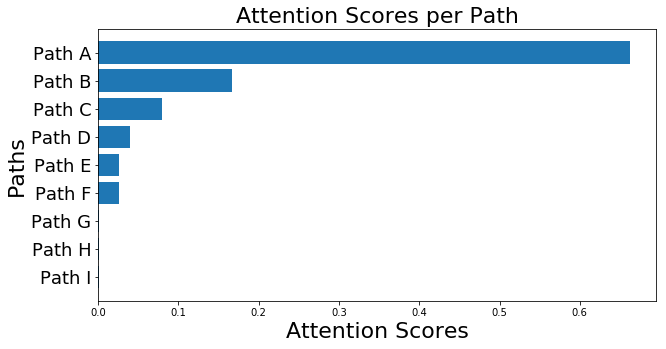

\textbf{Argument}: \mintinline[]{python}{colors$<$END$>$}\\
\textbf{D}: list of keys in the `` seaborn.xkcd\_rgb `` dictionary .\\
\textbf{P}: a list of data to read . if none , all other the first will be returned .\\
\begin{listing}[h!]
\begin{minted}[]{python}
def xkcd_palette(colors):
    """

    """
    palette = [xkcd_rgb[name] for name in colors]
    return color_palette(palette, len(palette))

\end{minted}
\end{listing}



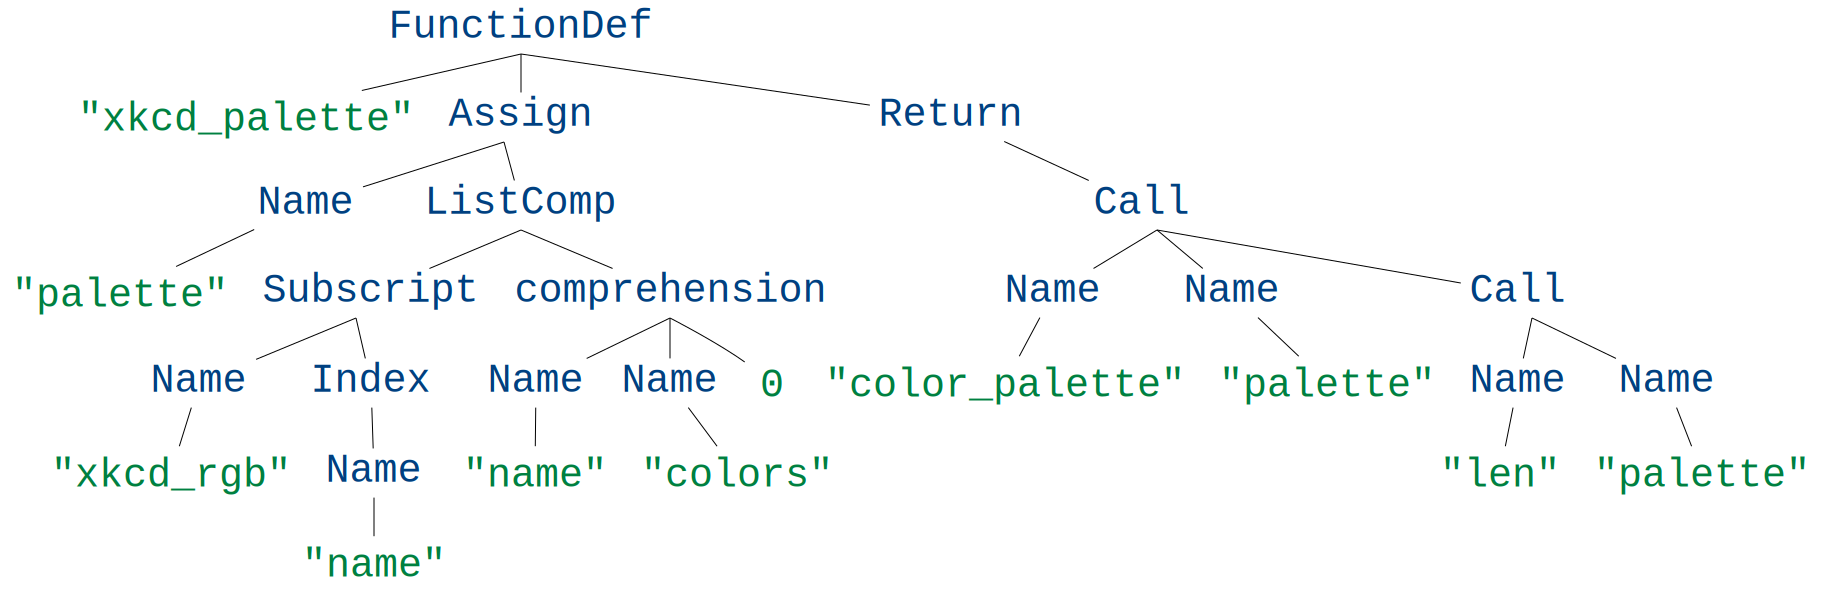

In [14]:
import showastfork
import importlib
importlib.reload(showastfork)
import project.utils.code_tokenize as ct


def get_attn_translation(nn, sess, data):
    [attn] =  nn._feed_fwd(sess, data, [nn.attention_scores] )
    trans = get_translations(nn, data)
    return zip(attn, trans[-1], data[2], data[3])

def generate_reports_GRAPH_TABLE_TREE_CODE(comb_faves, data_input, max_no, nn, sess):
    x = []
    i = 0 
    for (attn, trans, paths, tvs), comb in zip(get_attn_translation(nn,sess, data_input), comb_faves):
        plot_attention_single(attn, trans, paths, tvs)
        print(latex_translation(trans))
        print(src_to_latex(ct.get_pure_src(comb[1])) )
        x.append(showastfork.show_ast(ct.get_ast(comb[1]), get_settings(), True))
        i += 1
        if i == max_no:
            break
    # save_graph('xkcd_palette_strip', x[0])

comb_faves = load_examples("COMBINED_FAVES_REPORT")
data_input = stack_from_comb(comb_faves, 10)
generate_reports_GRAPH_TABLE_TREE_CODE(comb_faves, data_input, 1, nn, sess)

In [15]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [17]:
def get_all_attention_weights(nn, data):
    nn._do_shuffle = False
    attention, translation = [], []
    for i, mb in nn._to_batch(data):
        [attn, trans] =  nn._feed_fwd(sess, mb, [nn.attention_scores, nn.inference_id])
        attention.append(attn)
        translation.append(trans)
    return attention, translation, data

    
attn_weights, all_trans, data = get_all_attention_weights(nn, data_tuple.valid)


In [150]:
def plot_hist(x, y):
    fig, ax = plt.subplots(1, figsize=(16,8))
    
    ax.hist(x, density=True , bins=50, alpha=0.5, label='Code2Vec Model')
    ax.hist(y, density=True, bins=50, alpha=0.5, label='Uniform Categorical Distribution')
    ax.set_title("Histogram of Attention Entropy for Code2Vec Decoder Model", fontsize=22)
#     yt = ax.get_yticks()
#     set 
#     yt = ["{:.2f}%".format(y)  for y in  100*yt/len(x)]
#     ax.set_yticklabels( yt, rotation=0,  fontsize=18)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(18) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(18) 
    ax.set_ylabel("Frequency (%)", fontsize=22)
    ax.set_xlabel("Attention Entropies", fontsize=22)
    ax.legend(fontsize = 'xx-large')
    plt.show()

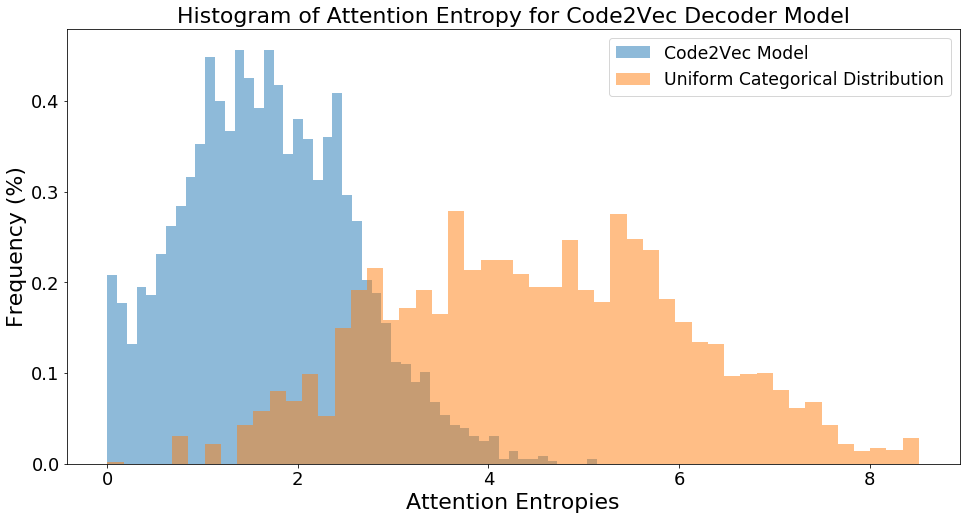

In [154]:
(attn_weights_c2v, all_trans_c2v, entropiesc2v) = load_examples( "FOURTH_FIFTH_attn_weight_entropies_CODE2VEC_SOLO",  )
rows = [np.trim_zeros(row) for array in attn_weights for row in array]

entropies = [-np.sum(r * np.log(r)) for r in rows]
uniform_entropies = [-np.log(1./len(r)) for r in rows]

plot_hist(entropies,uniform_entropies)
# sorted(uniform_entropies)

In [ ]:
for i, c in zip(range(5), comb):
    print(c[1]['src'])

In [ ]:
y = [(i, d) for i, d in enumerate(zip(*data_tuple.test))]
y[0]
RAW_TEST_DATA[0]
data_tuple.test[-1][0]

In [ ]:
# bleu_bootstrap = get_bleu_bootstrap(T[-1], sample_size=1000, no_samples=1000)

In [ ]:
# print("{:.5f}, {:.5f}".format(np.mean(bleu_bootstrap), np.std(bleu_bootstrap)))

# print("{:.5f}, {:.5f}".format(np.mean(sorted(bleu_bootstrap)[25:-25]), np.std(sorted(bleu_bootstrap)[25:-25])))

In [ ]:

def find_egs()

In [ ]:
import pickle
from collections import namedtuple

Examples = namedtuple("Examples", ["translations", "data_tuple"])
def find_examples(translations, data_tuple):
    return_index = []
    return_data = [[] for  _ in data_tuple.test]
    for t in translations:
        for i,d in enumerate(data_tuple.test[-1]):
            arg_name = "".join(nn.translate(data_tuple.test[0][i], lookup=nn.idx2char, do_join=False))
            if d == t.description and arg_name == t.name:
                return_index.append(i)
    
    for j in return_index:
        for k, d in enumerate(return_data):
            d.append(data_tuple.test[k][j])
    
    return [np.stack(x) for x in return_data[:-1]] + [return_data[-1]]

def load_examples(name):
    with open("examples/{}.eg.pkl".format(name), 'rb') as f:
         examples = pickle.load(f)
    return examples

def save_examples(name, good_data_tuple):
    with open("examples/{}.eg.pkl".format(name), 'wb') as f:
        pickle.dump(good_data_tuple, f)


### 2 Funcname Otherargs

In [ ]:
# good_examples = [T[3][i] for i in [10, 12, 23, 83, 192, 213, 237, 240, 247, 263]]
# data_examples = find_examples(good_examples, data_tuple)        
# egs = Examples(good_examples,data_examples )
# egs = load_examples('second_exp_funcname_otherargs')

In [ ]:
from project.data.preprocessed import load_vocab
path2idx, path2cnt = load_vocab('no_dups_X', 'quickload_paths')
tv2idx, tv2cnt = load_vocab('no_dups_X', 'quickload_tvs')
idx2tv = {v:k for k,v in tv2idx.items()}
idx2path ={v:k for k,v in path2idx.items()}

def translate_paths(paths, tvs):
    return["{} : {}".format(idx2path[p], idx2tv[t]) for p,t in zip(np.trim_zeros(paths), np.trim_zeros(tvs))]

In [ ]:
# import tensorflow as tf
from matplotlib import pyplot as plt
j = 132
just_one = [ i[j:j+1] for i in data_tuple.test ]
paths = np.trim_zeros(just_one[2][0])
tvs = np.trim_zeros(just_one[3][0])
ptvs = translate_paths(paths, tvs)


path2idx, path2cnt = load_vocab('no_dups_1', 'quickload_paths')
tv2idx, tv2cnt = load_vocab('no_dups_1', 'quickload_tvs')
attention, translate = nn._feed_fwd(sess, just_one, [nn.attention_scores, nn.inference_id] )
# char_input = nn.translate(just_one[0][0], lookup=nn.idx2char, do_join=False)


word_output = nn.translate(translate[0], do_join=False)
print(word_output)
# # print(np.trim_zeros(just_one[0][0]).shape)

attn = np.trim_zeros(attention[0])
plt.figure(figsize=(8,8))
_, c = attention.shape
plt.bar(np.arange(len(attn)), attn)
plt.xticks(np.arange(len(ptvs)), ptvs, rotation=90)
# plt.yticks(np.arange(len(word_output)), word_output)
# print(moved.shape)
plt.show()


In [ ]:
# 10, 12, 23, 83, 192, 213, 237, 240, 247, 263, 
for i, t in enumerate(good_examples):
    print(i,t)

In [ ]:
char_embeddings = nn.get_scope_variable(sess, 'embed_vars', 'char_embed')

In [ ]:
len(data_tuple.test[-1])


In [ ]:
#"\n".join("\t".join([str(j) for j in i]) for i in char_embeddings[0]) 
print("\n".join(["Char"] + [nn.idx2char[i] for i in sorted(nn.idx2char.keys())]))
